# TensorFlow

**[ODE-01]** 必要なモジュールをインポートして、乱数のシードを設定します。

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

np.random.seed(20160703)
tf.set_random_seed(20160703)

/Users/yohei/.pyenv/versions/anaconda3-5.0.0/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**[ODE-02]** データファイル「ORENIST.data」から画像とラベルのデータを読み込みます。

In [2]:
with open('ORENIST.data', 'rb') as file:
    images, labels = pickle.load(file, encoding='latin1')

**[ODE-03]** 画像データにフィルターとプーリング層を適用する計算式を用意します。

In [3]:
x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1,28,28,1])  # NHWC

# Variable として定義 [filter_height, filter_width, in_channels, out_channels]
W_conv = tf.Variable(tf.truncated_normal(shape=[5,5,1,2], stddev=0.1))
h_conv = tf.abs(tf.nn.conv2d(x_image, W_conv,
                             strides=[1,1,1,1], padding='SAME'))
h_conv_cutoff = tf.nn.relu(h_conv-0.2)

# poolingのkernel(window) size とstrideは同じ値に設定するのが一般的
# pooling のフィルタは学習すべきパラメータがなく，フィルタはデータ数・チャンネル数で共通の１つだけで良い
# よって必ずshape=[1, FH, FW, 1]である．
h_pool =tf.nn.max_pool(h_conv_cutoff, ksize=[1,2,2,1],
                       strides=[1,2,2,1], padding='SAME')

**[ODE-04]** プーリング層からの出力を全結合層とソフトマックス関数からなる「拡張された出力層」に入力する計算式を用意します。

In [4]:
h_pool_flat = tf.reshape(h_pool, [-1, 392])

num_units1 = 392
num_units2 = 2

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.zeros([num_units2]))
hidden2 = tf.nn.tanh(tf.matmul(h_pool_flat, w2) + b2)

w0 = tf.Variable(tf.zeros([num_units2, 3]))
b0 = tf.Variable(tf.zeros([3]))
p = tf.nn.softmax(tf.matmul(hidden2, w0) + b0)

**[ODE-05]** 誤差関数 loss、トレーニングアルゴリズム train_step、正解率 accuracy を定義します。

In [5]:
t = tf.placeholder(tf.float32, [None, 3])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer().minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

**[ODE-06]** セッションを用意して、Variable を初期化します。

In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**[ODE-07]** パラメーターの最適化を200回繰り返します。

In [7]:
i = 0
for _ in range(200):
    i += 1
    sess.run(train_step, feed_dict={x:images, t:labels})
    if i % 10 == 0:
        loss_val, acc_val = sess.run(
            [loss, accuracy], feed_dict={x:images, t:labels})
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

Step: 10, Loss: 98.618591, Accuracy: 0.644444
Step: 20, Loss: 98.038139, Accuracy: 0.677778
Step: 30, Loss: 97.233788, Accuracy: 0.722222
Step: 40, Loss: 96.181183, Accuracy: 0.811111
Step: 50, Loss: 94.913757, Accuracy: 0.833333
Step: 60, Loss: 93.212646, Accuracy: 0.877778
Step: 70, Loss: 91.002678, Accuracy: 0.922222
Step: 80, Loss: 88.412369, Accuracy: 0.955556
Step: 90, Loss: 85.766693, Accuracy: 0.955556
Step: 100, Loss: 83.228378, Accuracy: 0.977778
Step: 110, Loss: 80.836937, Accuracy: 0.988889
Step: 120, Loss: 78.676086, Accuracy: 1.000000
Step: 130, Loss: 76.683273, Accuracy: 1.000000
Step: 140, Loss: 74.864006, Accuracy: 1.000000
Step: 150, Loss: 73.193794, Accuracy: 1.000000
Step: 160, Loss: 71.621918, Accuracy: 1.000000
Step: 170, Loss: 70.129677, Accuracy: 1.000000
Step: 180, Loss: 68.704201, Accuracy: 1.000000
Step: 190, Loss: 67.337036, Accuracy: 1.000000
Step: 200, Loss: 66.022026, Accuracy: 1.000000


**[ODE-08]** 最適化後の畳込みフィルターの値と、最初の9個分の画像データに対して、畳み込みフィルターとプーリング層を適用した結果を取得します。

In [8]:
filter_vals, conv_vals, pool_vals = sess.run(
    [W_conv, h_conv_cutoff, h_pool], feed_dict={x:images[:9]})
filter_vals.shape

(5, 5, 1, 2)

**[ODE-09]** 畳込みフィルターを適用した結果を画像として表示します。

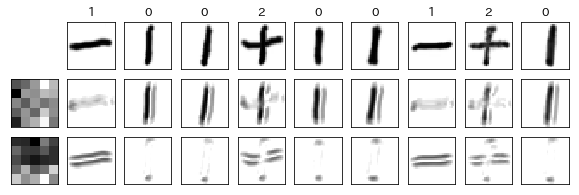

In [9]:
fig = plt.figure(figsize=(10,3))

v_max = np.max(conv_vals)

# フィルターを表示
for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, interpolation='nearest')

# 学習データとそれにフィルターを適用した後を表示
for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))
    # 学習データ
    subplot.imshow(images[i].reshape((28,28)), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')
    
    # filter1を適用後
    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_vals[i,:,:,0], vmin=0, vmax=v_max,
                   cmap=plt.cm.gray_r, interpolation='nearest')
    
    # filter2を適用後
    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_vals[i,:,:,1], vmin=0, vmax=v_max,
                   cmap=plt.cm.gray_r, interpolation='nearest')

**[ODE-10]** 畳込みフィルターとプーリング層を適用した結果を画像として表示します。

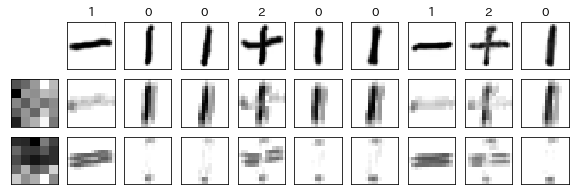

In [10]:
fig = plt.figure(figsize=(10,3))

v_max = np.max(pool_vals)

for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, interpolation='nearest')

for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))
    subplot.imshow(images[i].reshape((28,28)), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')
    
    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(pool_vals[i,:,:,0], vmin=0, vmax=v_max,
                   cmap=plt.cm.gray_r, interpolation='nearest')
    
    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(pool_vals[i,:,:,1], vmin=0, vmax=v_max,
                   cmap=plt.cm.gray_r, interpolation='nearest')

# Keras

In [40]:
from keras.models import Sequential
from keras.layers.core import Activation, Lambda, Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.initializers import TruncatedNormal, Zeros
from keras import backend as K

In [42]:
# 正則化に適用する関数は自由に定義できるが，引数にshapeとnameをとる．
def weight_variable(shape, name=None):
    # バックエンドKはtensorflowとなる．
    return K.truncated_normal(shape, stddev=0.1)

In [54]:
model = Sequential()

In [55]:
model.add(Conv2D(filters=2, kernel_size=5,
                 padding="same",
                 data_format="channels_last",
                 use_bias=False,
                 input_shape=(28, 28, 1),
                kernel_initializer=weight_variable, # 単にkernel_initializer=TruncatedNormal(stddev=0.1)でもOK
                 name='conv'))
model.add(Lambda(lambda x: x - 0.2))
model.add(Activation('relu', name='conv_cut_off'))
model.add(MaxPooling2D(pool_size=(2, 2),
                       padding="same", 
                       data_format="channels_last", name='pool'))
model.add(Flatten())  #  入力を平滑化する．バッチサイズに影響されない．
model.add(Dense(units=2))
model.add(Activation('tanh'))
model.add(Dense(units=3))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv (Conv2D)                (None, 28, 28, 2)         50        
_________________________________________________________________
lambda_5 (Lambda)            (None, 28, 28, 2)         0         
_________________________________________________________________
conv_cut_off (Activation)    (None, 28, 28, 2)         0         
_________________________________________________________________
pool (MaxPooling2D)          (None, 14, 14, 2)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 786       
_________________________________________________________________
activation_9 (Activation)    (None, 2)                 0         
__________

In [56]:
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])

In [57]:
x = np.array(images)
x = x.reshape([-1,28,28,1])

# 学習
hist = model.fit(x, labels, batch_size=x.shape[0], 
                 epochs=200,
                 validation_data=(x, labels))

Train on 90 samples, validate on 90 samples
Epoch 1/200
90/90 [==============================] - 1s 6ms/step - loss: 1.0791 - acc: 0.4000 - val_loss: 1.0753 - val_acc: 0.4000
Epoch 2/200
90/90 [==============================] - 0s 411us/step - loss: 1.0753 - acc: 0.4000 - val_loss: 1.0713 - val_acc: 0.4000
Epoch 3/200
90/90 [==============================] - 0s 530us/step - loss: 1.0713 - acc: 0.4000 - val_loss: 1.0670 - val_acc: 0.4111
Epoch 4/200
90/90 [==============================] - 0s 507us/step - loss: 1.0670 - acc: 0.4111 - val_loss: 1.0625 - val_acc: 0.4333
Epoch 5/200
90/90 [==============================] - 0s 530us/step - loss: 1.0625 - acc: 0.4333 - val_loss: 1.0577 - val_acc: 0.4333
Epoch 6/200
90/90 [==============================] - 0s 526us/step - loss: 1.0577 - acc: 0.4333 - val_loss: 1.0525 - val_acc: 0.4333
Epoch 7/200
90/90 [==============================] - 0s 513us/step - loss: 1.0525 - acc: 0.4333 - val_loss: 1.0471 - val_acc: 0.4444
Epoch 8/200
90/90 [========

Epoch 62/200
90/90 [==============================] - 0s 570us/step - loss: 0.5654 - acc: 0.9889 - val_loss: 0.5586 - val_acc: 0.9889
Epoch 63/200
90/90 [==============================] - 0s 602us/step - loss: 0.5586 - acc: 0.9889 - val_loss: 0.5521 - val_acc: 0.9889
Epoch 64/200
90/90 [==============================] - 0s 658us/step - loss: 0.5521 - acc: 0.9889 - val_loss: 0.5457 - val_acc: 0.9889
Epoch 65/200
90/90 [==============================] - 0s 714us/step - loss: 0.5457 - acc: 0.9889 - val_loss: 0.5396 - val_acc: 0.9889
Epoch 66/200
90/90 [==============================] - 0s 599us/step - loss: 0.5396 - acc: 0.9889 - val_loss: 0.5338 - val_acc: 0.9889
Epoch 67/200
90/90 [==============================] - 0s 494us/step - loss: 0.5338 - acc: 0.9889 - val_loss: 0.5282 - val_acc: 0.9889
Epoch 68/200
90/90 [==============================] - 0s 512us/step - loss: 0.5282 - acc: 0.9889 - val_loss: 0.5229 - val_acc: 0.9889
Epoch 69/200
90/90 [==============================] - 0s 448us

Epoch 123/200
90/90 [==============================] - 0s 513us/step - loss: 0.3980 - acc: 1.0000 - val_loss: 0.3968 - val_acc: 1.0000
Epoch 124/200
90/90 [==============================] - 0s 530us/step - loss: 0.3968 - acc: 1.0000 - val_loss: 0.3956 - val_acc: 1.0000
Epoch 125/200
90/90 [==============================] - 0s 442us/step - loss: 0.3956 - acc: 1.0000 - val_loss: 0.3944 - val_acc: 1.0000
Epoch 126/200
90/90 [==============================] - 0s 496us/step - loss: 0.3944 - acc: 1.0000 - val_loss: 0.3933 - val_acc: 1.0000
Epoch 127/200
90/90 [==============================] - 0s 524us/step - loss: 0.3933 - acc: 1.0000 - val_loss: 0.3921 - val_acc: 1.0000
Epoch 128/200
90/90 [==============================] - 0s 498us/step - loss: 0.3921 - acc: 1.0000 - val_loss: 0.3910 - val_acc: 1.0000
Epoch 129/200
90/90 [==============================] - 0s 505us/step - loss: 0.3910 - acc: 1.0000 - val_loss: 0.3899 - val_acc: 1.0000
Epoch 130/200
90/90 [==============================] - 

Epoch 184/200
90/90 [==============================] - 0s 499us/step - loss: 0.3406 - acc: 1.0000 - val_loss: 0.3398 - val_acc: 1.0000
Epoch 185/200
90/90 [==============================] - 0s 463us/step - loss: 0.3398 - acc: 1.0000 - val_loss: 0.3390 - val_acc: 1.0000
Epoch 186/200
90/90 [==============================] - 0s 514us/step - loss: 0.3390 - acc: 1.0000 - val_loss: 0.3383 - val_acc: 1.0000
Epoch 187/200
90/90 [==============================] - 0s 433us/step - loss: 0.3383 - acc: 1.0000 - val_loss: 0.3375 - val_acc: 1.0000
Epoch 188/200
90/90 [==============================] - 0s 523us/step - loss: 0.3375 - acc: 1.0000 - val_loss: 0.3367 - val_acc: 1.0000
Epoch 189/200
90/90 [==============================] - 0s 469us/step - loss: 0.3367 - acc: 1.0000 - val_loss: 0.3360 - val_acc: 1.0000
Epoch 190/200
90/90 [==============================] - 0s 446us/step - loss: 0.3360 - acc: 1.0000 - val_loss: 0.3353 - val_acc: 1.0000
Epoch 191/200
90/90 [==============================] - 

InvalidArgumentError トラブルシューティング

https://stackoverflow.com/questions/39480314/tensorflow-invalidargumenterror-you-must-feed-a-value-for-placeholder-tensor-wi

In [18]:
model.layers

In [58]:
filter_vals = model.get_layer('conv').get_weights()[0]
filter_vals.shape

(5, 5, 1, 2)

In [59]:
x = np.array(images)
x = x.reshape([-1,28,28,1])
x.shape

(90, 28, 28, 1)

In [60]:
# 中間層の出力を得るためには新たなModel を作成
layer_name = 'conv_cut_off'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output) # 入力がinputで出力層は欲しい中間層のTensor
conv_vals = intermediate_layer_model.predict(x[:9])

In [61]:
conv_vals.shape

(9, 28, 28, 2)

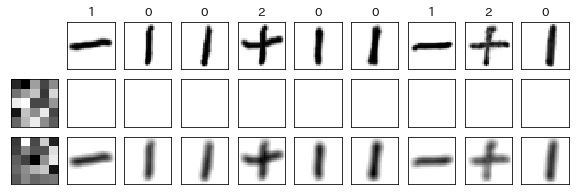

In [62]:
fig = plt.figure(figsize=(10,3))

v_max = np.max(conv_vals)

# フィルターを表示
for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, interpolation='nearest')

# 学習データとそれにフィルターを適用した後を表示
for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))
    # 学習データ
    subplot.imshow(images[i].reshape((28,28)), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')
    
    # filter1を適用後
    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_vals[i,:,:,0], vmin=0, vmax=v_max,
                   cmap=plt.cm.gray_r, interpolation='nearest')
    
    # filter2を適用後
    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_vals[i,:,:,1], vmin=0, vmax=v_max,
                   cmap=plt.cm.gray_r, interpolation='nearest')

In [63]:
# 中間層の出力を得るためには新たなModel を作成
layer_name = 'pool'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output) # 入力がinputで出力層は欲しい中間層のTensor
pool_vals = intermediate_layer_model.predict(x[:9])

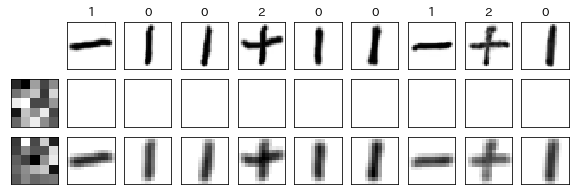

In [64]:
fig = plt.figure(figsize=(10,3))

v_max = np.max(pool_vals)

for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, interpolation='nearest')

for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))
    subplot.imshow(images[i].reshape((28,28)), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')
    
    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(pool_vals[i,:,:,0], vmin=0, vmax=v_max,
                   cmap=plt.cm.gray_r, interpolation='nearest')
    
    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(pool_vals[i,:,:,1], vmin=0, vmax=v_max,
                   cmap=plt.cm.gray_r, interpolation='nearest')